In [19]:
import cell_lineage_tracking as lineage
import tifffile
import matplotlib.pyplot as plt
from skimage.measure import find_contours
from skimage.draw import polygon
from matplotlib.collections import LineCollection
import pandas as pd
import numpy as np

In [6]:
def plot_kymograph_cells_id(phase_kymograph, fluor_kymograph, full_region_df, folder, fov_id, peak_id, fig_dir, track_id_col='track_id'):
    fig, ax = plt.subplots(2,1, figsize=(40, 10))

    # Get kymograph shape once for both calls
    kymograph_shape = phase_kymograph.shape

    ax[0].imshow(phase_kymograph, cmap = 'grey')
    _plot_cell_masks(ax[0], full_region_df, kymograph_shape, y_coord_col = 'centroid_y', x_coord_col = 'centroid_x', lineage_col = track_id_col)
    ax[0].set_yticks([])
    ax[0].set_xticks([])
    ax[0].set_title(f'Phase Kymograph - {folder} FOV: {fov_id}, trench: {peak_id}')

    ax[1].imshow(fluor_kymograph, cmap = 'grey')
    _plot_cell_masks(ax[1], full_region_df, kymograph_shape, y_coord_col = 'centroid_y', x_coord_col = 'centroid_x', lineage_col = track_id_col)
    ax[1].set_yticks([])
    ax[1].set_xticks([])
    ax[1].set_title(f'Fluorescence Kymograph - {folder} FOV: {fov_id}, trench: {peak_id}')

    plt.xlabel("Time frames")
    plt.tight_layout()
    #plt.savefig(fig_dir)
    #plt.close(fig)

def _plot_cell_masks(ax, full_region_df, kymograph_shape, y_coord_col = 'centroid_y', x_coord_col = 'centroid_x', lineage_col = None):
    default_cell_contour_color = '#AA5486'
    default_centroid_color = '#FC8F54'
    text_color = 'white' # Color for the track ID text
    text_offset_x = 5 # Offset the text slightly from the centroid to avoid overlap
    text_offset_y = 0

    # Prepare data for LineCollection for contours
    all_contours_segments = []
    all_contour_colors = []
    
    # Prepare data for centroids
    centroid_x_coords = []
    centroid_y_coords = []
    centroid_colors = []

    all_text_params = []

    if lineage_col:
        unique_track_ids = full_region_df[lineage_col].dropna().unique()
        colors_cmap = plt.get_cmap('tab20', len(unique_track_ids))
        track_colors = {track_id: colors_cmap(i) for i, track_id in enumerate(unique_track_ids)}

    for index, region_props in full_region_df.iterrows():
        # 'coords' are assumed to be (row, col) pixels within the mask
        cell_pixel_coords = np.array(region_props['coords']) # e.g., [[r1,c1], [r2,c2], ...]

        # Calculate bounding box for the current cell's mask
        min_row, min_col = np.min(cell_pixel_coords, axis=0)
        max_row, max_col = np.max(cell_pixel_coords, axis=0)

        # Create a small temporary mask for the current cell
        # Add a small buffer to ensure contours are fully captured if they go to edge
        buffer = 1
        bbox_min_row = max(0, min_row - buffer)
        bbox_min_col = max(0, min_col - buffer)
        bbox_max_row = min(kymograph_shape[0], max_row + buffer)
        bbox_max_col = min(kymograph_shape[1], max_col + buffer)

        temp_mask_shape = (bbox_max_row - bbox_min_row + 1, bbox_max_col - bbox_min_col + 1)
        temp_mask = np.zeros(temp_mask_shape, dtype=np.uint8)

        # Map cell_pixel_coords to relative coordinates within temp_mask
        relative_rows = cell_pixel_coords[:, 0] - bbox_min_row
        relative_cols = cell_pixel_coords[:, 1] - bbox_min_col
        
        # Populate the temporary mask
        temp_mask[relative_rows, relative_cols] = 1

        # Find contours on this small temporary mask
        # level=0.5 means it finds contours at the boundary between 0 and 1
        # fully_connected='high' means it considers 8-connectivity for background, 4-connectivity for foreground
        contours = find_contours(temp_mask, level=0.5, fully_connected='high')

        if not contours:
            continue # Skip if no contour found (e.g., single pixel or degenerate mask)

        # `find_contours` returns (row, col) coordinates for the contour.
        # We need to convert them back to global kymograph coordinates.
        # And convert to (x, y) for plotting (col, row)
        global_contours = []
        for contour in contours:
            # Shift back to global coordinates and swap for (x, y) plotting
            global_contour_x = contour[:, 1] + bbox_min_col
            global_contour_y = contour[:, 0] + bbox_min_row
            global_contours.append(np.vstack([global_contour_x, global_contour_y]).T)

        y_coord = region_props[y_coord_col]
        x_coord = region_props[x_coord_col]
        
        # Determine color for the current cell
        if lineage_col and region_props[lineage_col] in track_colors:
            current_color = track_colors[region_props[lineage_col]]
        else:
            current_color = default_cell_contour_color

        # Add all contours for this cell to the main list, with the determined color
        for contour_segment in global_contours:
            all_contours_segments.append(contour_segment)
            all_contour_colors.append(current_color)
            
        # Add centroid data
        centroid_x_coords.append(x_coord)
        centroid_y_coords.append(y_coord)
        centroid_colors.append(current_color if lineage_col else default_centroid_color)
        
        # --- Add Track ID Text ---
        if lineage_col and pd.notna(region_props[lineage_col]):
            track_id = region_props[lineage_col]
            # Convert track_id to int if it's a float, for cleaner display
            if isinstance(track_id, float) and track_id.is_integer():
                track_id_display = int(track_id)
            else:
                track_id_display = track_id

            all_text_params.append({
                'x': x_coord + text_offset_x,
                'y': y_coord + text_offset_y,
                's': str(track_id_display),
                'color': text_color,
                'fontsize': 8,
                'ha': 'left', # horizontal alignment
                'va': 'center', # vertical alignment
                'bbox': dict(facecolor=current_color, edgecolor='none', alpha=0.6, pad=1.0) # Background box
            })

    # Plot all cell contours at once using LineCollection
    if all_contours_segments: # Only plot if there are segments to draw
        line_collection = LineCollection(all_contours_segments, colors=all_contour_colors, linewidths=0.5)
        ax.add_collection(line_collection)

    # Plot all centroids at once using scatter
    if centroid_x_coords: # Only plot if there are centroids
        ax.scatter(centroid_x_coords, centroid_y_coords, color=centroid_colors, s=5, zorder=2)
    # Plot all track ID text at once
    for params in all_text_params:
        ax.text(params['x'], params['y'], params['s'], color=params['color'],
                fontsize=params['fontsize'], ha=params['ha'], va=params['va'],
                bbox=params['bbox'])

In [122]:
folder = 'DUMM_giTG69_Glucose_013025'
all_cells_filename = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/all_cell_data_{folder}.pkl'
all_cells_pd = pd.read_pickle(all_cells_filename)

In [123]:
all_cells_pd.rename(columns = {'centroid-0': 'centroid_y','centroid-1': 'centroid_x'}, inplace = True)
all_cells_pd.loc[:,'node_id'] = all_cells_pd.index # Assign unique global node ID

In [124]:
all_cells_pd['track_id'] = all_cells_pd['track_id'].astype(np.int64)
all_cells_pd['track_id'] = all_cells_pd['track_id'].astype(str)

all_cells_pd.loc[:, 'ground_truth_lineage'] = None
all_cells_pd.loc[all_cells_pd['trench_id'] =='295', 'ground_truth_lineage']= all_cells_pd.loc[all_cells_pd['trench_id'] =='295','track_id'].map(ground_truth_lineage_id_dict_295)
all_cells_pd.loc[all_cells_pd['trench_id'] =='371', 'ground_truth_lineage']= all_cells_pd.loc[all_cells_pd['trench_id'] =='371','track_id'].map(ground_truth_lineage_id_dict_371)

In [125]:
all_cells_pd.to_pickle(all_cells_filename)

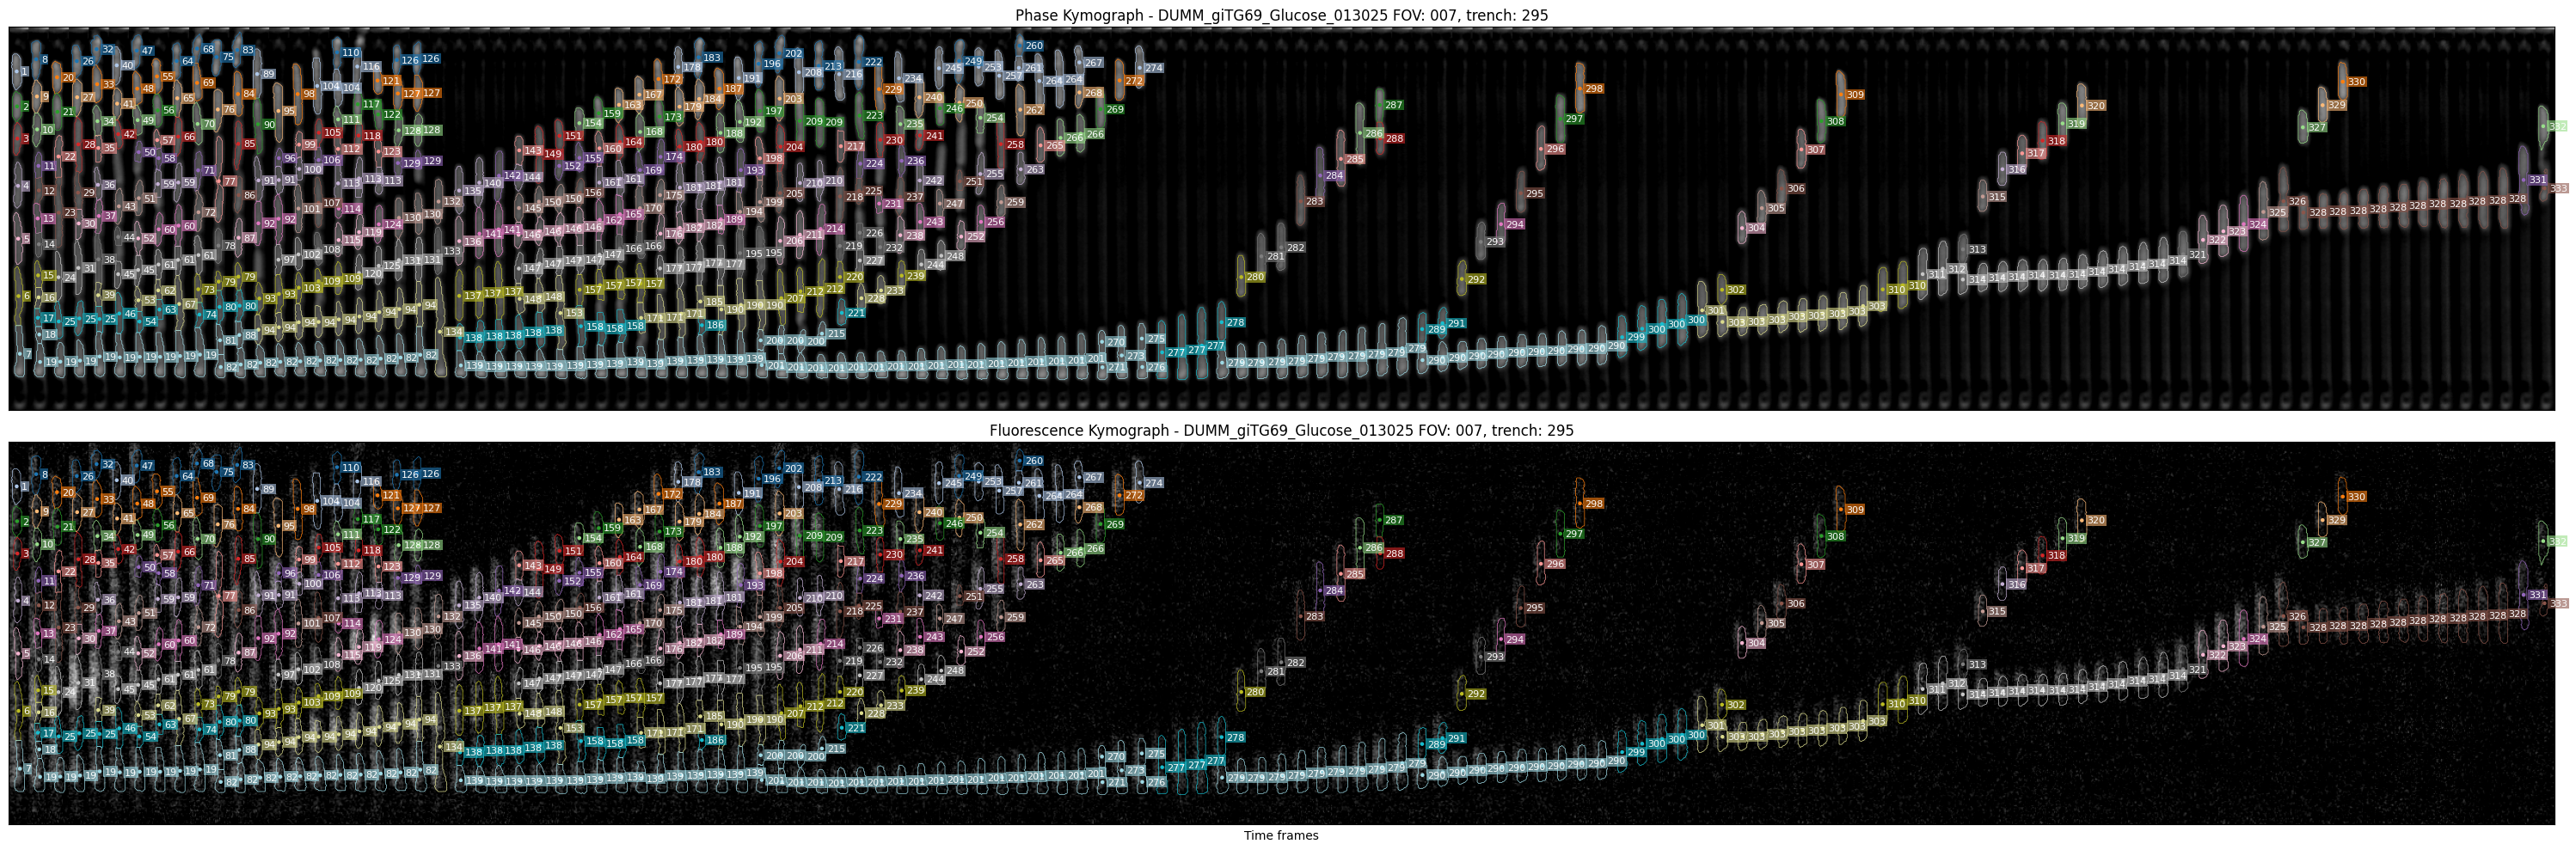

In [126]:
exp_view = folder
fov_view = '007'
trench_view = '295'
df_view = all_cells_pd[(all_cells_pd['experiment_name']==exp_view) &
                       (all_cells_pd['FOV']==fov_view) &
                       (all_cells_pd['trench_id']==trench_view)].copy()


# path_to_phase_kymograph = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{exp_view}/hyperstacked/drift_corrected/drift_cor_DuMM_xy005_re_c0_2025-Jun-3-001/Fast4DReg/rotated/mm_channels/subtracted/{fov_view}_{trench_view}.tif'
# path_to_fluor_kymograph = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{exp_view}//hyperstacked/drift_corrected/drift_cor_DuMM_xy005_re_c0_2025-Jun-3-001/Fast4DReg/rotated/mm_channels/subtracted/fluor/{fov_view}_{trench_view}.tif'


path_to_phase_kymograph = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{exp_view}/hyperstacked/drift_corrected/rotated/mm_channels/subtracted/{fov_view}_{trench_view}.tif'
path_to_fluor_kymograph = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{exp_view}/hyperstacked/drift_corrected/rotated/mm_channels/subtracted/fluor/{fov_view}_{trench_view}.tif'
phase_kymograph = tifffile.imread(path_to_phase_kymograph)
fluor_kymograph = tifffile.imread(path_to_fluor_kymograph)

plot_kymograph_cells_id(phase_kymograph, fluor_kymograph, 
                                    df_view, 
                                    exp_view, fov_view, trench_view, 
                                    None, 
                                    track_id_col='track_id')

In [10]:
#for fov 007 and trench id 295
# manually correcting lineages id from track id
ground_truth_lineage_id_dict_295 = {'7': 'A',
                                '25':'A.1',
                                '46':'A.1',
                                '67':'A.1',
                                '73':'A.1.1',
                                '79':'A.1.1',
                                '97':'A.1.1',
                                '102':'A.1.1',
                                '108':'A.1.1',
                                '115':'A.1.1',
                                '119':'A.1.1',
                                '124':'A.1.1',
                                '130':'A.1.1',
                                '132':'A.1.1',
                                '135':'A.1.1',
                                '140':'A.1.1',
                                '142':'A.1.1',
                                '143':'A.1.1.1',
                                '151':'A.1.1.1',
                                '154':'A.1.1.1',
                                '159':'A.1.1.1',
                                '163':'A.1.1.1',
                                '167':'A.1.1.1',
                                '172':'A.1.1.1',
                                '178':'A.1.1.1',
                                '183':'A.1.1.1',
                                '144':'A.1.1.2',
                                '152':'A.1.1.2',
                                '155':'A.1.1.2',
                                '160':'A.1.1.2',
                                '164':'A.1.1.2',
                                '168':'A.1.1.2',
                                '173':'A.1.1.2',
                                '179':'A.1.1.2',
                                '184':'A.1.1.2',
                                '187':'A.1.1.2',
                                '191':'A.1.1.2',
                                '196':'A.1.1.2',
                                '202':'A.1.1.2',
                                '74':'A.1.2',
                                '80':'A.1.2',
                                '93':'A.1.2',
                                '109':'A.1.2',
                                '120':'A.1.2',
                                '125':'A.1.2',
                                '131':'A.1.2',
                                '133':'A.1.2',
                                '136':'A.1.2',
                                '141':'A.1.2',
                                '145':'A.1.2.1',
                                '150':'A.1.2.1',
                                '156':'A.1.2.1',
                                '161':'A.1.2.1',
                                '169':'A.1.2.1',
                                '174':'A.1.2.1',
                                '180':'A.1.2.1',
                                '188':'A.1.2.1',
                                '192':'A.1.2.1',
                                '197':'A.1.2.1',
                                '203':'A.1.2.1',
                                '208':'A.1.2.1',
                                '213':'A.1.2.1',
                                '146':'A.1.2.2',
                                '162':'A.1.2.2',
                                '165':'A.1.2.2',
                                '170':'A.1.2.2',
                                '175':'A.1.2.2',
                                '181':'A.1.2.2',
                                '193':'A.1.2.2',
                                '198':'A.1.2.2',
                                '204':'A.1.2.2',
                                '209':'A.1.2.2',
                                '216':'A.1.2.2',
                                '222':'A.1.2.2',
                                '74':'A.1.2',
                                '19': 'A.2',
                                '81': 'A.2.1',
                                '88':'A.2.1',
                                '94':'A.2.1',
                                '137':'A.2.1',
                                '147':'A.2.1.1',
                                '166':'A.2.1.1',
                                '176':'A.2.1.1',
                                '182':'A.2.1.1',
                                '189':'A.2.1.1',
                                '194':'A.2.1.1',
                                '199':'A.2.1.1',
                                '205':'A.2.1.1',
                                '210':'A.2.1.1',
                                '217':'A.2.1.1',
                                '223':'A.2.1.1',
                                '229':'A.2.1.1',
                                '234':'A.2.1.1',
                                '148':'A.2.1.2',
                                '157':'A.2.1.2',
                                '177':'A.2.1.2',
                                '195':'A.2.1.2',
                                '206':'A.2.1.2',
                                '211':'A.2.1.2',
                                '214':'A.2.1.2',
                                '218':'A.2.1.2',
                                '224':'A.2.1.2.1',
                                '230':'A.2.1.2.1',
                                '235':'A.2.1.2.1',
                                '240':'A.2.1.2.1',
                                '245':'A.2.1.2.1',
                                '249':'A.2.1.2.1',
                                '225':'A.2.1.2.2',
                                '82': 'A.2.2',
                                '138':'A.2.2.1',
                                '158':'A.2.2.1',
                                '171':'A.2.2.1',
                                '190':'A.2.2.1',
                                '207':'A.2.2.1',
                                '212':'A.2.2.1',
                                '220':'A.2.2.1',
                                '227':'A.2.2.1',
                                '232':'A.2.2.1',
                                '238':'A.2.2.1',
                                '243':'A.2.2.1',
                                '247':'A.2.2.1',
                                '255':'A.2.2.1',
                                '258':'A.2.2.1',
                                '262':'A.2.2.1',
                                '264':'A.2.2.1',
                                '267':'A.2.2.1.1',
                                '268':'A.2.2.1.2',
                                '139':'A.2.2.2',
                                '200': 'A.2.2.2.1',
                                '215': 'A.2.2.2.1',
                                '221': 'A.2.2.2.1',
                                '228': 'A.2.2.2.1',
                                '233': 'A.2.2.2.1',
                                '239': 'A.2.2.2.1',
                                '244': 'A.2.2.2.1',
                                '248': 'A.2.2.2.1',
                                '252': 'A.2.2.2.1',
                                '256': 'A.2.2.2.1',
                                '259': 'A.2.2.2.1',
                                '263': 'A.2.2.2.1',
                                '265': 'A.2.2.2.1',
                                '266': 'A.2.2.2.1',
                                '269': 'A.2.2.2.1',
                                '272': 'A.2.2.2.1',
                                '274': 'A.2.2.2.1',
                                '201': 'A.2.2.2.2',
                                '273': 'A.2.2.2.2',
                                '277': 'A.2.2.2.2',
                                '278': 'A.2.2.2.2.1',
                                '280': 'A.2.2.2.2.1',
                                '281': 'A.2.2.2.2.1',
                                '282': 'A.2.2.2.2.1',
                                '283': 'A.2.2.2.2.1',
                                '284': 'A.2.2.2.2.1',
                                '285': 'A.2.2.2.2.1',
                                '286': 'A.2.2.2.2.1',
                                '287': 'A.2.2.2.2.1.1',
                                '288': 'A.2.2.2.2.1.2',
                                '279': 'A.2.2.2.2.2',
                                '289': 'A.2.2.2.2.1',
                                '291': 'A.2.2.2.2.1',
                                '292': 'A.2.2.2.2.1',
                                '293': 'A.2.2.2.2.1',
                                '294': 'A.2.2.2.2.1',
                                '295': 'A.2.2.2.2.1',
                                '296': 'A.2.2.2.2.1',
                                '297': 'A.2.2.2.2.1',
                                '298': 'A.2.2.2.2.1',
                                '290': 'A.2.2.2.2.2.2',
                                '299': 'A.2.2.2.2.2.2',
                                '300': 'A.2.2.2.2.2.2',
                                '301': 'A.2.2.2.2.2.2',
                                '302': 'A.2.2.2.2.2.2.1',
                                '304': 'A.2.2.2.2.2.2.1',
                                '305': 'A.2.2.2.2.2.2.1',
                                '306': 'A.2.2.2.2.2.2.1',
                                '307': 'A.2.2.2.2.2.2.1',
                                '308': 'A.2.2.2.2.2.2.1',
                                '309': 'A.2.2.2.2.2.2.1',
                                '303': 'A.2.2.2.2.2.2.2',
                                '310': 'A.2.2.2.2.2.2.2',
                                '311': 'A.2.2.2.2.2.2.2',
                                '312': 'A.2.2.2.2.2.2.2',
                                '313': 'A.2.2.2.2.2.2.2.1',
                                '315': 'A.2.2.2.2.2.2.2.1',
                                '316': 'A.2.2.2.2.2.2.2.1',
                                '317': 'A.2.2.2.2.2.2.2.1',
                                '318': 'A.2.2.2.2.2.2.2.1',
                                '319': 'A.2.2.2.2.2.2.2.1',
                                '320': 'A.2.2.2.2.2.2.2.1',
                                '314': 'A.2.2.2.2.2.2.2.2',
                                '321': 'A.2.2.2.2.2.2.2.2',
                                '322': 'A.2.2.2.2.2.2.2.2',
                                '323': 'A.2.2.2.2.2.2.2.2',
                                '324': 'A.2.2.2.2.2.2.2.2',
                                '325': 'A.2.2.2.2.2.2.2.2',
                                '326': 'A.2.2.2.2.2.2.2.2',
                                '327': 'A.2.2.2.2.2.2.2.2.1',
                                '329': 'A.2.2.2.2.2.2.2.2.1',
                                '330': 'A.2.2.2.2.2.2.2.2.1',
                                '328': 'A.2.2.2.2.2.2.2.2.2',
                                '331': 'A.2.2.2.2.2.2.2.2.2',
                                '332': 'A.2.2.2.2.2.2.2.2.2.1',
                                '333': 'A.2.2.2.2.2.2.2.2.2.2'}

In [11]:
#for fov 007 and trench id 371
# manually correcting lineages id from track id
ground_truth_lineage_id_dict_371 = {'11': 'A',
                                '12': 'A',
                                '13': 'A',
                                '14':'A.1',
                                '17':'A.1',
                                '20':'A.1',
                                '22':'A.1',
                                '24':'A.1',
                                '27':'A.1',
                                '30':'A.1.1',
                                '33':'A.1.1',
                                '36':'A.1.1',
                                '38':'A.1.1',
                                '15':'A.2',
                                '18':'A.2',
                                '21':'A.2',
                                '23':'A.2',
                                '25':'A.2.1',
                                '28':'A.2.1',
                                '35':'A.2.1',
                                '40':'A.2.1',
                                '26':'A.2.2',
                                '29':'A.2.2',
                                '41':'A.2.2.1',
                                '43':'A.2.2.1',
                                '45':'A.2.2.1',
                                '46':'A.2.2.1.1',
                                '48':'A.2.2.1.1',
                                '50':'A.2.2.1.1',
                                '53':'A.2.2.1.1',
                                '47':'A.2.2.1.2',
                                '49':'A.2.2.1.2',
                                '51':'A.2.2.1.2',
                                '54':'A.2.2.1.2',
                                '55':'A.2.2.1.2',
                                '58':'A.2.2.1.2',
                                '61':'A.2.2.1.2',
                                '64':'A.2.2.1.2',
                                '66':'A.2.2.1.2',
                                '67':'A.2.2.1.2',
                                '69':'A.2.2.1.2',
                                '42':'A.2.2.2',
                                '44':'A.2.2.2',
                                '52':'A.2.2.2',
                                '56':'A.2.2.2.1',
                                '62':'A.2.2.2.1',
                                '65':'A.2.2.2.1',
                                '70':'A.2.2.2.1',
                                '74':'A.2.2.2.1',
                                '57':'A.2.2.2.2',
                                '63':'A.2.2.2.2',
                                '71':'A.2.2.2.2',
                                '74':'A.2.2.2.1',
                                '76':'A.2.2.2.1.1',
                                '80':'A.2.2.2.1.1',
                                '86':'A.2.2.2.1.1',
                                '94':'A.2.2.2.1.1',
                                '97':'A.2.2.2.1.1',
                                '104':'A.2.2.2.1.1',
                                '77':'A.2.2.2.1.2',
                                '81':'A.2.2.2.1.2',
                                '87':'A.2.2.2.1.2',
                                '95':'A.2.2.2.1.2',
                                '98':'A.2.2.2.1.2',
                                '105':'A.2.2.2.1.2',
                                '106':'A.2.2.2.1.2',
                                '108':'A.2.2.2.1.2', 
                                '72':'A.2.2.1.2.1',
                                '78':'A.2.2.1.2.1',
                                '73':'A.2.2.1.2.2',
                                '79':'A.2.2.1.2.2',
                                '85':'A.2.2.1.2.2',
                                '89':'A.2.2.1.2.2',
                                '90':'A.2.2.1.2.2',
                                '101':'A.2.2.1.2.2',
                                '104':'A.2.2.1.2.2',
                                '82':'A.2.2.2.2.1',
                                '88':'A.2.2.2.2.1',
                                '107':'A.2.2.2.2.1',
                                '109':'A.2.2.2.2.1.1',
                                '114':'A.2.2.2.2.1.1',
                                '118':'A.2.2.2.2.1.1',
                                '121':'A.2.2.2.2.1.1',
                                '123':'A.2.2.2.2.1.1',
                                '124':'A.2.2.2.2.1.1',
                                '127':'A.2.2.2.2.1.1',
                                '129':'A.2.2.2.2.1.1',
                                '133':'A.2.2.2.2.1.1',
                                '135':'A.2.2.2.2.1.1',
                                '138':'A.2.2.2.2.1.1',
                                '144':'A.2.2.2.2.1.1.2',
                                '156':'A.2.2.2.2.1.1.2',
                                '162':'A.2.2.2.2.1.1.2',
                                '168':'A.2.2.2.2.1.1.2',
                                '172':'A.2.2.2.2.1.1.2',
                                '177':'A.2.2.2.2.1.1.2',
                                '182':'A.2.2.2.2.1.1.2',
                                '188':'A.2.2.2.2.1.1.2',
                                '196':'A.2.2.2.2.1.1.2',
                                '143':'A.2.2.2.2.1.1.1',
                                '150':'A.2.2.2.2.1.1.1',
                                '155':'A.2.2.2.2.1.1.1',
                                '161':'A.2.2.2.2.1.1.1',
                                '167':'A.2.2.2.2.1.1.1',
                                '170':'A.2.2.2.2.1.1.1.1',
                                '171':'A.2.2.2.2.1.1.1.2',
                                '110':'A.2.2.2.2.1.2',
                                '115':'A.2.2.2.2.1.2',
                                '130':'A.2.2.2.2.1.2',
                                '134':'A.2.2.2.2.1.2',
                                '136':'A.2.2.2.2.1.2',
                                '140':'A.2.2.2.2.1.2.2',
                                '152':'A.2.2.2.2.1.2.2',
                                '158':'A.2.2.2.2.1.2.2',
                                '164':'A.2.2.2.2.1.2.2',
                                '174':'A.2.2.2.2.1.2.2',
                                '179':'A.2.2.2.2.1.2.2',
                                '184':'A.2.2.2.2.1.2.2',
                                '190':'A.2.2.2.2.1.2.2',
                                '198':'A.2.2.2.2.1.2.2',
                                '204':'A.2.2.2.2.1.2.2',
                                '209':'A.2.2.2.2.1.2.2',
                                '213':'A.2.2.2.2.1.2.2',
                                '217':'A.2.2.2.2.1.2.2',
                                '223':'A.2.2.2.2.1.2.2.1',
                                '224':'A.2.2.2.2.1.2.2.2',
                                '139':'A.2.2.2.2.1.2.1',
                                '151':'A.2.2.2.2.1.2.1',
                                '157':'A.2.2.2.2.1.2.1',
                                '163':'A.2.2.2.2.1.2.1',
                                '169':'A.2.2.2.2.1.2.1',
                                '173':'A.2.2.2.2.1.2.1',
                                '178':'A.2.2.2.2.1.2.1',
                                '183':'A.2.2.2.2.1.2.1',
                                '189':'A.2.2.2.2.1.2.1',
                                '197':'A.2.2.2.2.1.2.1',
                                '203':'A.2.2.2.2.1.2.1',
                                '208':'A.2.2.2.2.1.2.1',
                                '212':'A.2.2.2.2.1.2.1',
                                '83':'A.2.2.2.2.2',
                                '91':'A.2.2.2.2.2',
                                '111':'A.2.2.2.2.2.1',
                                '116':'A.2.2.2.2.2.1',
                                '146':'A.2.2.2.2.2.1.1',
                                '165':'A.2.2.2.2.2.1.1',
                                '175':'A.2.2.2.2.2.1.1',
                                '185':'A.2.2.2.2.2.1.1',
                                '191':'A.2.2.2.2.2.1.1',
                                '199':'A.2.2.2.2.2.1.1',
                                '205':'A.2.2.2.2.2.1.1',
                                '210':'A.2.2.2.2.2.1.1',
                                '214':'A.2.2.2.2.2.1.1',
                                '218':'A.2.2.2.2.2.1.1',
                                '225':'A.2.2.2.2.2.1.1',
                                '230':'A.2.2.2.2.2.1.1.1',
                                '231':'A.2.2.2.2.2.1.1.2',
                                '112':'A.2.2.2.2.2.2',
                                '117':'A.2.2.2.2.2.2',
                                '122':'A.2.2.2.2.2.2',
                                '128':'A.2.2.2.2.2.2',
                                '137':'A.2.2.2.2.2.2'}

for key, value in ground_truth_lineage_id_dict_371.items():
    ground_truth_lineage_id_dict_371[key] = value.replace('A', 'G')

In [ ]:
ground_truth_lineage_id_dict_1061 = {
    '72': 'B.2.2',
    '94': 'B.2.2',
    '102': 'B.2.2',
    '122': 'B.2.2.2',
    '126': 'B.2.2.2',
    '129': 'B.2.2.2',
    '135': 'B.2.2.2',
    '136': 'B.2.2.2',
    '138': 'B.2.2.2',
    '139': 'B.2.2.2.1',
    '145': 'B.2.2.2.1',
    '140': 'B.2.2.2.2',

    
    '121': 'B.2.2.1',
    '128': 'B.2.2.1',
    '134': 'B.2.2.1',
    '143': 'B.2.2.1.1',
    '144': 'B.2.2.1.2',
    
    '3': 'B',
    '8': 'B',
    '12': 'B',
    '17': 'B.2',
    '66': 'B.2',
    '71': 'B.2.1',
    '93': 'B.2.1',
    '101': 'B.2.1',
    '119': 'B.2.1',
    '120': 'B.2.1',
    '123': 'B.2.1',
    '124': 'B.2.1',
    '127': 'B.2.1',
    '130': 'B.2.1.1',
    '132': 'B.2.1.1',
    '137': 'B.2.1.1',
    '141': 'B.2.1.1',
    '131': 'B.2.1.2',
    '133': 'B.2.1.2',
    '142': 'B.2.1.2',
    
    '44': 'B.1.2',
    '92': 'B.1.2',
    '114': 'B.1.2',
    '117': 'B.1.2.1',
    '118': 'B.1.2.2',
    
    '16': 'B.1',
    '43': 'B.1.1',
    '49': 'B.1.1',
    '54': 'B.1.1',
    '59': 'B.1.1',
    '65': 'B.1.1',
    '70': 'B.1.1',
    '80': 'B.1.1',
    '98': 'B.1.1',
    '113': 'B.1.1',
    '115': 'B.1.1.1',
    '116': 'B.1.1.2',

    '23': 'A.2.2',
    '31': 'A.2.2',
    '35': 'A.2.2',
    '42': 'A.2.2',
    '48': 'A.2.2',
    '53': 'A.2.2',
    '58': 'A.2.2',
    '64': 'A.2.2',
    '69': 'A.2.2',
    '84': 'A.2.2.1',
    '90': 'A.2.2.1',
    '105': 'A.2.2.1',
    '111': 'A.2.2.1',
    '85': 'A.2.2.2',
    '97': 'A.2.2.2',
    '112': 'A.2.2.2',
    
    '11': 'A.2',
    '22': 'A.2.1',
    '26': 'A.2.1',
    '28': 'A.2.1',
    '30': 'A.2.1',
    '34': 'A.2.1',
    '38': 'A.2.1',
    '41': 'A.2.1',
    '47': 'A.2.1',
    '52': 'A.2.1',
    '57': 'A.2.1',
    '63': 'A.2.1',
    '75': 'A.2.1',
    '78': 'A.2.1',
    '89': 'A.2.1',
    '95': 'A.2.1.1',
    '103': 'A.2.1.1',
    '109': 'A.2.1.1',
    '96': 'A.2.1.2',
    '104': 'A.2.1.2',
    '110': 'A.2.1.2',
    
    '2': 'A',
    '7': 'A',
    '10': 'A.1',
    '13': 'A.1',
    '14': 'A.1',
    '15': 'A.1',
    '18': 'A.1',
    '20': 'A.1',
    '21': 'A.1',
    '24': 'A.1',
    '25': 'A.1',
    '27': 'A.1',
    '29': 'A.1',
    '33': 'A.1.2',
    '37': 'A.1.2',
    '40': 'A.1.2',
    '46': 'A.1.2',
    '51': 'A.1.2',
    '74': 'A.1.2',
    '77': 'A.1.2',
    '81': 'A.1.2',
    
    '32': 'A.1.1',
    '36': 'A.1.1',
    '39': 'A.1.1',
    '45': 'A.1.1',
    '50': 'A.1.1',
    '55': 'A.1.1',
    '62': 'A.1.1',
    '67': 'A.1.1',
}

In [111]:
ground_truth_lineage_id_dict_1565 = {'203': 'H',
                                     '207': 'H',
                                     '209': 'H',
                                     '213': 'H',
                                     '216': 'H',
                                     '219': 'H',
                                     '227': 'H.1',
                                     '228': 'H.2',
                                     '296': 'G',
                                     '300': 'G.2',
                                     '306': 'G.2',
                                     '311': 'G.2',
                                     '314': 'G.2',
                                     '319': 'G.2',
                                     '322': 'G.2',
                                     '324': 'G.2',
                                     '299': 'G.1',
                                     '305': 'G.1',
                                     '310': 'G.1',
                                     '313': 'G.1',
                                     '318': 'G.1',
                                     '321': 'G.1',
                                     '226': 'F.1.2',
                                     '235': 'F.1.2',
                                     '241': 'F.1.2',
                                     '248': 'F.1.2',
                                     '252': 'F.1.2',
                                     '255': 'F.1.2',
                                     '257': 'F.1.2.1',
                                     '258': 'F.1.2.2',
                                     '212': 'F.2',
                                     '242': 'F.2',
                                     '249': 'F.2',
                                     '261': 'F.2',
                                     '275': 'F.2.2',
                                     '282': 'F.2.2',
                                     '287': 'F.2.2',
                                     '292': 'F.2.2',
                                     '295': 'F.2.2',
                                     '298': 'F.2.2',
                                     '302': 'F.2.2.2',
                                     '304': 'F.2.2.2',
                                     '309': 'F.2.2.2',
                                     '312': 'F.2.2.2',
                                     '317': 'F.2.2.2',
                                     '320': 'F.2.2.2',
                                     '323': 'F.2.2.2',
                                     '205': 'F',
                                     '211': 'F.1',
                                     '215': 'F.1',
                                     '218': 'F.1',
                                     '222': 'F.1',
                                     '225': 'F.1.1',
                                     '231': 'F.1.1',
                                     '234': 'F.1.1',
                                     '240': 'F.1.1',
                                     '247': 'F.1.1',
                                     '251': 'F.1.1',
                                     '254': 'F.1.1',
                                     '256': 'F.1.1',
                                     '259': 'F.1.1',
                                     '262': 'F.1.1.1',
                                     '267': 'F.1.1.1',
                                     '158': 'E.2',
                                     '163': 'E.2',
                                     '166': 'E.2',
                                     '169': 'E.2',
                                     '186': 'E.2.1',
                                     '187': 'E.2.2',
                                     '123': 'E',
                                     '132': 'E',
                                     '137': 'E',
                                     '140': 'E',
                                     '147': 'E',
                                     '151': 'E.1',
                                     '156': 'E.1',
                                     '157': 'E.1',
                                     '162': 'E.1',
                                     '165': 'E.1',
                                     '168': 'E.1',
                                     '172': 'E.1',
                                     '177': 'E.1',
                                     '184': 'E.1.1',
                                     '190': 'E.1.1',
                                     '185': 'E.1.2',
                                     '191': 'E.1.1',
                                     '122': 'D',
                                     '125': 'D',
                                     '126': 'D.1',
                                     '128': 'D.1',
                                     '130': 'D.1',
                                     '135': 'D.1',
                                     '138': 'D.1',
                                     '142': 'D.1',
                                     '127': 'D.2',
                                     '129': 'D.2',
                                     '131': 'D.2',
                                     '136': 'D.2',
                                     '139': 'D.2',
                                     '143': 'D.2',
                                     '150': 'D.2.2',
                                     '74': 'C.2',
                                     '92': 'C.2',
                                     '102': 'C.2.1',
                                     '107': 'C.2.1',
                                     '114': 'C.2.1',
                                    '117': 'C.1.2',
                                    '113': 'C.1.2',
                                    '111': 'C.1.2',
                                    '101': 'C.1.2',
                                     '91': 'C.1.2',
                                     '73': 'C.1',
                                     '79': 'C.1',
                                     '89': 'C.1',
                                     '91': 'C.1',
                                     '2': 'B',
                                     '4': 'B',
                                     '10': 'B.1',
                                     '19': 'B.1',
                                     '28': 'B.1',
                                     '11': 'B.2',
                                     '1': 'A',
                                     '3': 'A',
                                     '5': 'A',
                                     '6': 'A.1',
                                     '8': 'A.1',
                                     '14': 'A.1.1',
                                     '18': 'A.1.1',
                                     '20': 'A.1.1',
                                     '26': 'A.1.1',
                                     '29': 'A.1.1',
                                     '33': 'A.1.1',
                                     '7': 'A.2',
                                     '9': 'A.2',
                                     '15': 'A.2',
                                     '17': 'A.2',
                                     '23': 'A.2.2',
                                     '32': 'A.2.2',
                                     '46': 'A.2.2',
                                     '38': 'C',
                                     '42': 'C',
                                     '50': 'C',
                                     '54': 'C',
                                     '64': 'C'}

In [ ]:
ground_truth_lineage_id_dict_1826 = {
    '98': 'A.2.2.2.2',
    '107': 'A.2.2.2.2',
    '117': 'A.2.2.2.2.2',
    '143': 'A.2.2.2.2.2.2',
    '151': 'A.2.2.2.2.2.2',
    '167': 'A.2.2.2.2.2.2',
    '177': 'A.2.2.2.2.2.2',
    '179': 'A.2.2.2.2.2.2.2',
    '188': 'A.2.2.2.2.2.2.2.2',
    '203': 'A.2.2.2.2.2.2.2.2',
    '207': 'A.2.2.2.2.2.2.2.2',
    '212': 'A.2.2.2.2.2.2.2.2.1',
    '213': 'A.2.2.2.2.2.2.2.2.2',
    '187': 'A.2.2.2.2.2.2.2.1',
    '191': 'A.2.2.2.2.2.2.2.1',
    '194': 'A.2.2.2.2.2.2.2.1',
    '197': 'A.2.2.2.2.2.2.2.1',
    '202': 'A.2.2.2.2.2.2.2.1',
    '206': 'A.2.2.2.2.2.2.2.1',
    '210': 'A.2.2.2.2.2.2.2.1.1',
    '211': 'A.2.2.2.2.2.2.2.1.2',
    '178': 'A.2.2.2.2.2.2.1',
    '180': 'A.2.2.2.2.2.2.1',
    '181': 'A.2.2.2.2.2.2.1',
    '183': 'A.2.2.2.2.2.2.1.2',
    '185': 'A.2.2.2.2.2.2.1.2',
    '190': 'A.2.2.2.2.2.2.1.2',
    '193': 'A.2.2.2.2.2.2.1.2',
    '196': 'A.2.2.2.2.2.2.1.2',
    '200': 'A.2.2.2.2.2.2.1.2.1',
    '204': 'A.2.2.2.2.2.2.1.2.1',
    '208': 'A.2.2.2.2.2.2.1.2.1',
    '201': 'A.2.2.2.2.2.2.1.2.2',
    '205': 'A.2.2.2.2.2.2.1.2.2',
    '209': 'A.2.2.2.2.2.2.1.2.2',
    '182': 'A.2.2.2.2.2.2.1.1',
    '184': 'A.2.2.2.2.2.2.1.1',
    '186': 'A.2.2.2.2.2.2.1.1',
    '189': 'A.2.2.2.2.2.2.1.1',
    '192': 'A.2.2.2.2.2.2.1.1',
    '195': 'A.2.2.2.2.2.2.1.1',
    '142': 'A.2.2.2.2.2.1',
    '150': 'A.2.2.2.2.2.1',
    '155': 'A.2.2.2.2.2.1',
    '159': 'A.2.2.2.2.2.1',
    '161': 'A.2.2.2.2.2.1',
    '165': 'A.2.2.2.2.2.1.1', # revise
    '166': 'A.2.2.2.2.2.1.2',
    '116': 'A.2.2.2.2.1',
    '122': 'A.2.2.2.2.1',
    '129': 'A.2.2.2.2.1',
    '141': 'A.2.2.2.2.1.2',
    '146': 'A.2.2.2.2.1.2',
    '154': 'A.2.2.2.2.1.2',
    '158': 'A.2.2.2.2.1.2',
    '140': 'A.2.2.2.2.1.1',
    '145': 'A.2.2.2.2.1.1',
    '149': 'A.2.2.2.2.1.1',
    '153': 'A.2.2.2.2.1.1',
    '157': 'A.2.2.2.2.1.1',
    '169': 'A.2.2.2.2.1.1.1',
    '170': 'A.2.2.2.2.1.1.1',
    '63': 'A.2.1.2.2',
    '69': 'A.2.1.2.2',
    '71': 'A.2.1.2.2',
    '75': 'A.2.1.2.2',
    '78': 'A.2.1.2.2',
    '80': 'A.2.1.2.2',
    '84': 'A.2.1.2.2.1',
    '85': 'A.2.1.2.2.2',
    '4': 'A.2',
    '6': 'A.2',
    '8': 'A.2',
    '12': 'A.2.2',
    '22': 'A.2.2',
    '65': 'A.2.2.2',
    '67': 'A.2.2.2',
    '73': 'A.2.2.2',
    '92': 'A.2.2.2',
    '97': 'A.2.2.2.1',
    '102': 'A.2.2.2.1',
    '106': 'A.2.2.2.1',
    '111': 'A.2.2.2.1',
    '115': 'A.2.2.2.1.2',
    '121': 'A.2.2.2.1.2',
    '126': 'A.2.2.2.1.2',
    '139': 'A.2.2.2.1.2.1',
    '144': 'A.2.2.2.1.2.2',
    '148': 'A.2.2.2.1.2.2',
    '152': 'A.2.2.2.1.2.2',
    '156': 'A.2.2.2.1.2.2',
    '160': 'A.2.2.2.1.2.2',
    '162': 'A.2.2.2.1.2.2.1',
    '163': 'A.2.2.2.1.2.2.2',
    '114': 'A.2.2.2.1.1',
    '120': 'A.2.2.2.1.1',
    '125': 'A.2.2.2.1.1',
    '135': 'A.2.2.2.1.1.1',
    '64': 'A.2.2.1',
    '72': 'A.2.2.1',
    '76': 'A.2.2.1',
    '81': 'A.2.2.1',
    '87': 'A.2.2.1.2',
    '91': 'A.2.2.1.2',
    '96': 'A.2.2.1.2',
    '101': 'A.2.2.1.2',
    '105': 'A.2.2.1.2',
    '110': 'A.2.2.1.2',
    '113': 'A.2.2.1.2.2',
    '119': 'A.2.2.1.2.2',
    '124': 'A.2.2.1.2.2',
    '127': 'A.2.2.1.2.2',
    '112': 'A.2.2.1.2.1',
    '118': 'A.2.2.1.2.1',
    '123': 'A.2.2.1.2.1',
    '86': 'A.2.2.1.1',
    '90': 'A.2.2.1.1',
    '95': 'A.2.2.1.1',
    '100': 'A.2.2.1.1',
    '104': 'A.2.2.1.1',
    '11': 'A.2.1',
    '21': 'A.2.1',
    '36': 'A.2.1',
    '42': 'A.2.1.1',
    '47': 'A.2.1.1',
    '43': 'A.2.1.2',
    '48': 'A.2.1.2',
    '54': 'A.2.1.2',
    '58': 'A.2.1.2',
    '62': 'A.2.1.2.1',
    '66': 'A.2.1.2.1',
    '68': 'A.2.1.2.1',
    '70': 'A.2.1.2.1',
    '74': 'A.2.1.2.1',
    '77': 'A.2.1.2.1',
    '79': 'A.2.1.2.1',
    '82': 'A.2.1.2.1',
    '83': 'A.2.1.2.1',
    '93': 'A.2.1.2.1.1',
    '99': 'A.2.1.2.1.1',
    '1': 'A',
    '2': 'A',
    '3': 'A.1',
    '5': 'A.1',
    '7': 'A.1',
    '9': 'A.1',
    '10': 'A.1',
    '14': 'A.1.2',
    '16': 'A.1.2',
    '18': 'A.1.2', #track needs to be reassigned
    '31': 'A.1.2.2',
    '35': 'A.1.2.2',
    '39': 'A.1.2.2',
    '46': 'A.1.2.2',
    '25': 'A.1.2.1',
    '28': 'A.1.2.1',
    '30': 'A.1.2.1',
    '34': 'A.1.2.1',
    '38': 'A.1.2.1',
    '41': 'A.1.2.1',
    '45': 'A.1.2.1',
    '51': 'A.1.2.1',
    '52': 'A.1.2.1',
    '13': 'A.1.1',
    '15': 'A.1.1',
    '17': 'A.1.1',
    '20': 'A.1.1',
    '24': 'A.1.1.2',
    '27': 'A.1.1.2',
    '29': 'A.1.1.2',
    '33': 'A.1.1.2',
    '37': 'A.1.1.2',
    '55': 'A.1.1.2.1',
    '23': 'A.1.1.1',
    '26': 'A.1.1.1',
    '32': 'A.1.1.1',
    '40': 'A.1.1.1',
    '44': 'A.1.1.1',
    '49': 'A.1.1.1.1',
    '50': 'A.1.1.1.1',
    
}

In [211]:
ground_truth_lineage_id_dict_843 = {
    '1': 'C',
    '4': 'C',
    '8': 'C.1',
    '11': 'C.1',
    '15': 'C.1',
    '19': 'C.1',
    '9':'C.2',
    '16':'C.2',
    
    '2':'B',
    '6':'B',
    '13':'B',
    '17':'B',
    '22':'B',
    '25':'B',
    '27':'B',
    '29':'B',
    '31':'B',
    '32':'B',
    '36':'B',
    '40':'B',
    '43':'B',
    '48':'B',
    '55':'B',
    '59':'B',
    '63':'B',
    '64':'B',
    '71':'B',
    
    '3':'A',
    '7':'A',
    '14':'A',
    '20':'A',
    '21':'A',
    '23':'A',
    '24':'A',
    '26':'A',
    '28':'A',
    '30':'A',
    '34':'A.1',
    '38':'A.1',
    '41':'A.1',
    '42':'A.1',
    '44':'A.1',
    '51':'A.1',
    '52':'A.1',
    '62':'A.1',
    '65':'A.1.1',
    '72':'A.1.1',
    
    '66':'A.1.2',
    '67':'A.1.2',
    '73':'A.1.2',
    '75':'A.1.2',
    '78':'A.1.2',
    
    '35':'A.2',
    '39':'A.2',
    '47':'A.2',
    '53':'A.2',
    '54':'A.2',
    '58':'A.2',
    '68':'A.2.1',
    '76':'A.2.2.2.2.2.1',
    '79':'A.2.2.2.2.2.1',
    
    '69':'A.2.2',
    '77':'A.2.2',
    '80':'A.2.2',
    }

# was thinking change in time between time frames should be a feature in the GNN nodes, don't just limit to linking t+1
ground_truth_lineage_id_dict_867 = {
    '278': 'B.2.2.2.2.2.2.2.1.2',
    '284': 'B.2.2.2.2.2.2.2.1.2',
    '295': 'B.2.2.2.2.2.2.2.1.2',
    '298': 'B.2.2.2.2.2.2.2.1.2',
    '301': 'B.2.2.2.2.2.2.2.1.2',
    '309': 'B.2.2.2.2.2.2.2.1.2',
    '312': 'B.2.2.2.2.2.2.2.1.2',
    
    '131': 'B.2.2.2.2.2.2',
    '141': 'B.2.2.2.2.2.2',
    '160': 'B.2.2.2.2.2.2',
    '166': 'B.2.2.2.2.2.2.2',
    '171': 'B.2.2.2.2.2.2.2',
    '184': 'B.2.2.2.2.2.2.2',
    '194': 'B.2.2.2.2.2.2.2',
    '205': 'B.2.2.2.2.2.2.2.2',
    '272': 'B.2.2.2.2.2.2.2.2.2',
    '290': 'B.2.2.2.2.2.2.2.2.2',
    '303': 'B.2.2.2.2.2.2.2.2.2',
    '311': 'B.2.2.2.2.2.2.2.2.2',
    '315': 'B.2.2.2.2.2.2.2.2.2.2',
    '325': 'B.2.2.2.2.2.2.2.2.2.2',
    
    '314': 'B.2.2.2.2.2.2.2.2.2.1',
    '318': 'B.2.2.2.2.2.2.2.2.2.1',
    '324': 'B.2.2.2.2.2.2.2.2.2.1',
    '326': 'B.2.2.2.2.2.2.2.2.2.1',
    '331': 'B.2.2.2.2.2.2.2.2.2.1',
    
    '236': 'B.2.2.2.2.2.2.2.2.1',
    '260': 'B.2.2.2.2.2.2.2.2.1',
    '264': 'B.2.2.2.2.2.2.2.2.1',
    '279': 'B.2.2.2.2.2.2.2.2.1',
    '302': 'B.2.2.2.2.2.2.2.2.1',
    '310': 'B.2.2.2.2.2.2.2.2.1',
    '313': 'B.2.2.2.2.2.2.2.2.1',
    '313': 'B.2.2.2.2.2.2.2.2.1.2',
    '317': 'B.2.2.2.2.2.2.2.2.1.2',
    '320': 'B.2.2.2.2.2.2.2.2.1.2',
    '323': 'B.2.2.2.2.2.2.2.2.1.2',
    '328': 'B.2.2.2.2.2.2.2.2.1.2',
    '330': 'B.2.2.2.2.2.2.2.2.1.2',
    
    '316': 'B.2.2.2.2.2.2.2.2.1.1',
    '319': 'B.2.2.2.2.2.2.2.2.1.1',
    '321': 'B.2.2.2.2.2.2.2.2.1.1',
    '322': 'B.2.2.2.2.2.2.2.2.1.1',
    '327': 'B.2.2.2.2.2.2.2.2.1.1',
    '329': 'B.2.2.2.2.2.2.2.2.1.1',


    
    '204': 'B.2.2.2.2.2.2.2.1',
    '218': 'B.2.2.2.2.2.2.2.1',
    '235': 'B.2.2.2.2.2.2.2.1',
    '252': 'B.2.2.2.2.2.2.2.1',
    '277': 'B.2.2.2.2.2.2.2.1.1',
    '283': 'B.2.2.2.2.2.2.2.1.1',
    '289': 'B.2.2.2.2.2.2.2.1.1',
    '294': 'B.2.2.2.2.2.2.2.1.1',
    '297': 'B.2.2.2.2.2.2.2.1.1',
    '306': 'B.2.2.2.2.2.2.2.1.1',


    
    '165': 'B.2.2.2.2.2.2.1',
    '170': 'B.2.2.2.2.2.2.1',
    '183': 'B.2.2.2.2.2.2.1',
    '193': 'B.2.2.2.2.2.2.1',
    '203': 'B.2.2.2.2.2.2.1',
    '211': 'B.2.2.2.2.2.2.1.2',
    '217': 'B.2.2.2.2.2.2.1.2',
    '234': 'B.2.2.2.2.2.2.1.2',
    '245': 'B.2.2.2.2.2.2.1.2',
    '251': 'B.2.2.2.2.2.2.1.2',
    '255': 'B.2.2.2.2.2.2.1.2',
    '259': 'B.2.2.2.2.2.2.1.2.2',
    '271': 'B.2.2.2.2.2.2.1.2.2',
    '276': 'B.2.2.2.2.2.2.1.2.2',
    '282': 'B.2.2.2.2.2.2.1.2.2',
    '293': 'B.2.2.2.2.2.2.1.2.2',
    '300': 'B.2.2.2.2.2.2.1.2.2',
    '305': 'B.2.2.2.2.2.2.1.2.2',
    
    '258': 'B.2.2.2.2.2.2.1.2.1',
    '262': 'B.2.2.2.2.2.2.1.2.1',
    '267': 'B.2.2.2.2.2.2.1.2.1',
    '270': 'B.2.2.2.2.2.2.1.2.1',
    '275': 'B.2.2.2.2.2.2.1.2.1',
    '281': 'B.2.2.2.2.2.2.1.2.1',
    '286': 'B.2.2.2.2.2.2.1.2.1',
    '288': 'B.2.2.2.2.2.2.1.2.1',
    '292': 'B.2.2.2.2.2.2.1.2.1',
    '296': 'B.2.2.2.2.2.2.1.2.1',

    
    '210': 'B.2.2.2.2.2.2.1.1',
    '216': 'B.2.2.2.2.2.2.1.1',
    '230': 'B.2.2.2.2.2.2.1.1',
    '240': 'B.2.2.2.2.2.2.1.1',
    '244': 'B.2.2.2.2.2.2.1.1',
    '250': 'B.2.2.2.2.2.2.1.1',
    '254': 'B.2.2.2.2.2.2.1.1',
    '257': 'B.2.2.2.2.2.2.1.1',
    '261': 'B.2.2.2.2.2.2.1.1',
    '265': 'B.2.2.2.2.2.2.1.1.1',
    '268': 'B.2.2.2.2.2.2.1.1.1',
    '266': 'B.2.2.2.2.2.2.1.1.2',
    '269': 'B.2.2.2.2.2.2.1.1.2',
    '274': 'B.2.2.2.2.2.2.1.1.2',
    '280': 'B.2.2.2.2.2.2.1.1.2',
    '285': 'B.2.2.2.2.2.2.1.1.2',
    '287': 'B.2.2.2.2.2.2.1.1.2',
    
    '151': 'B.2.2.2.2.2.1.2',
    '159': 'B.2.2.2.2.2.1.2',
    '164': 'B.2.2.2.2.2.1.2',
    '176': 'B.2.2.2.2.2.1.2',
    '188': 'B.2.2.2.2.2.1.2',
    '192': 'B.2.2.2.2.2.1.2',
    '197': 'B.2.2.2.2.2.1.2',
    '202': 'B.2.2.2.2.2.1.2.2',
    '209': 'B.2.2.2.2.2.1.2.2',
    '215': 'B.2.2.2.2.2.1.2.2',
    '225': 'B.2.2.2.2.2.1.2.2',
    '229': 'B.2.2.2.2.2.1.2.2',
    '233': 'B.2.2.2.2.2.1.2.2',
    '239': 'B.2.2.2.2.2.1.2.2',
    '243': 'B.2.2.2.2.2.1.2.2',
    '249': 'B.2.2.2.2.2.1.2.2',
    '253': 'B.2.2.2.2.2.1.2.2',
    '256': 'B.2.2.2.2.2.1.2.2',

    '201': 'B.2.2.2.2.2.1.2.1',
    '208': 'B.2.2.2.2.2.1.2.1',
    '214': 'B.2.2.2.2.2.1.2.1',
    '222': 'B.2.2.2.2.2.1.2.1',
    '224': 'B.2.2.2.2.2.1.2.1',
    '228': 'B.2.2.2.2.2.1.2.1',
    '232': 'B.2.2.2.2.2.1.2.1',
    '238': 'B.2.2.2.2.2.1.2.1',

    '2': 'B',
    '6': 'B.2',
    '7': 'B.2',
    '8': 'B.2',
    '9': 'B.2',
    '38': 'B.2',
    '48': 'B.2.2',
    '82': 'B.2.2.2',
    '100': 'B.2.2.2',
    '105': 'B.2.2.2.2',
    '119': 'B.2.2.2.2.2',
    '123': 'B.2.2.2.2.2',
    '130': 'B.2.2.2.2.2.1',
    '140': 'B.2.2.2.2.2.1',
    '145': 'B.2.2.2.2.2.1',
    '158': 'B.2.2.2.2.2.1.1',
    '163': 'B.2.2.2.2.2.1.1',
    '175': 'B.2.2.2.2.2.1.1',
    '179': 'B.2.2.2.2.2.1.1',
    '187': 'B.2.2.2.2.2.1.1',
    '200': 'B.2.2.2.2.2.1.1.2',
    '207': 'B.2.2.2.2.2.1.1.2',
    '213': 'B.2.2.2.2.2.1.1.2',
    '219': 'B.2.2.2.2.2.1.1.2',
    '221': 'B.2.2.2.2.2.1.1.2',
    '223': 'B.2.2.2.2.2.1.1.2',
    '196': 'B.2.2.2.2.2.1.1.1',
    '199': 'B.2.2.2.2.2.1.1.1',
    '206': 'B.2.2.2.2.2.1.1.1',
    '212': 'B.2.2.2.2.2.1.1.1',
    
    '118': 'B.2.2.2.2.1',
    '122': 'B.2.2.2.2.1',
    '124': 'B.2.2.2.2.1',
    '126': 'B.2.2.2.2.1.2',
    '136': 'B.2.2.2.2.1.2',
    '144': 'B.2.2.2.2.1.2.2',
    '157': 'B.2.2.2.2.1.2.2',
    '174': 'B.2.2.2.2.1.2.2',
    '178': 'B.2.2.2.2.1.2.2',
    '182': 'B.2.2.2.2.1.2.2',
    '186': 'B.2.2.2.2.1.2.2',
    '190': 'B.2.2.2.2.1.2.2',
    '195': 'B.2.2.2.2.1.2.2',
    
    '143': 'B.2.2.2.2.1.2.1',
    '147': 'B.2.2.2.2.1.2.1',
    '149': 'B.2.2.2.2.1.2.1',
    '156': 'B.2.2.2.2.1.2.1',
    '169': 'B.2.2.2.2.1.2.1',
    '173': 'B.2.2.2.2.1.2.1',
    '177': 'B.2.2.2.2.1.2.1',
    '181': 'B.2.2.2.2.1.2.1',
    
    '125': 'B.2.2.2.2.1.1',
    '127': 'B.2.2.2.2.1.1',
    '128': 'B.2.2.2.2.1.1',
    '129': 'B.2.2.2.2.1.1',
    '132': 'B.2.2.2.2.1.1',
    '134': 'B.2.2.2.2.1.1',
    '135': 'B.2.2.2.2.1.1',
    '137': 'B.2.2.2.2.1.1',
    '138': 'B.2.2.2.2.1.1',
    '139': 'B.2.2.2.2.1.1',
    '142': 'B.2.2.2.2.1.1',
    '146': 'B.2.2.2.2.1.1',
    '148': 'B.2.2.2.2.1.1',
    '154': 'B.2.2.2.2.1.1.1',
    
    '104': 'B.2.2.2.1',
    '114': 'B.2.2.2.1.2',
    '117': 'B.2.2.2.1.2',
    '121': 'B.2.2.2.1.2',
    
    '113': 'B.2.2.2.1.1',
    '115': 'B.2.2.2.1.1',
    '116': 'B.2.2.2.1.1',


    
    '81': 'B.2.2.1',
    '86': 'B.2.2.1',
    '99': 'B.2.2.1',
    '101': 'B.2.2.1',
    '102': 'B.2.2.1',
    '103': 'B.2.2.1',
    '107': 'B.2.2.1.2',
    '110': 'B.2.2.1.2',


    
    '106': 'B.2.2.1.1',
    '108': 'B.2.2.1.1',
    '109': 'B.2.2.1.1',
    '111': 'B.2.2.1.1',
    '112': 'B.2.2.1.1',

    
    '47': 'B.2.1',
    '72': 'B.2.1',
    '78': 'B.2.1',
    '91': 'B.2.1.2',
    '97': 'B.2.1.2',
    '90': 'B.2.1.1',
    '96': 'B.2.1.1',
    '5': 'B.1',
    '26': 'B.1',
    '32': 'B.1.2',
    '50': 'B.1.2',
    '58': 'B.1.2',
    '61': 'B.1.2',
    '71': 'B.1.2',
    '74': 'B.1.2',
    '77': 'B.1.2',
    '80': 'B.1.2',
    '89': 'B.1.2.2',
    '94': 'B.1.2.2',
    '95': 'B.1.2.2',
    '98': 'B.1.2.2',
    '85': 'B.1.2.1',
    '88': 'B.1.2.1',
    '93': 'B.1.2.1',
    '31': 'B.1.1',
    '37': 'B.1.1',
    '43': 'B.1.1',
    '54': 'B.1.1',
    '57': 'B.1.1',
    '60': 'B.1.1',
    '64': 'B.1.1',
    '67': 'B.1.1',
    '70': 'B.1.1',
    '76': 'B.1.1',
    '79': 'B.1.1',
    '83': 'B.1.1.1',
    '84': 'B.1.1.2',
    '87': 'B.1.1.2',
    '92': 'B.1.1.2',

    
    '1': 'A',
    '4': 'A.2',
    '11': 'A.2',
    '13': 'A.2',
    '18': 'A.2.2',
    '25': 'A.2.2',
    '30': 'A.2.2',
    '36': 'A.2.2',
    '42': 'A.2.2',
    '46': 'A.2.2',
    '53': 'A.2.2',
    '59': 'A.2.2',
    '63': 'A.2.2',
    '66': 'A.2.2.2',
    '69': 'A.2.2.2',
    '73': 'A.2.2.2',
    '75': 'A.2.2.2',
    '65': 'A.2.2.1',
    '68': 'A.2.2.1',
    '17': 'A.2.1',
    '21': 'A.2.1',
    '24': 'A.2.1',
    '29': 'A.2.1',
    '35': 'A.2.1',
    '41': 'A.2.1',
    '45': 'A.2.1',
    '52': 'A.2.1',
    '55': 'A.2.1', 
    '3': 'A.1',
    '10': 'A.1',
    '12': 'A.1',
    '14': 'A.1',
    '15': 'A.1.1',
    '19': 'A.1.1',
    '22': 'A.1.1',
    '27': 'A.1.1',
    '33': 'A.1.1',
    '16': 'A.1.2',
    '20': 'A.1.2',
    '23': 'A.1.2',
    '28': 'A.1.2',
    '34': 'A.1.2',
    '40': 'A.1.2',
    '44': 'A.1.2',
    '49': 'A.1.2',
}

In [280]:
# 'DUMM_giTG69_Glucose_013025' done
# 'DUMM_giTG068_063_061725' work in progress for giTG68 fov '012' trench '1565'
# 'DUMM_giTG068_052925' fov 005 trench 539, done by Adrian
# 'DUMM_giTG059_060_061125' done mazF fov '015', trench '1826'
# 'DUMM_giTG059_noKan_Glucose_031125' # fov '004', trench '1061' done
# 'DUMM_giTG064_Glucose_022625' fov '001', trench id '867' done
# '20241205': # giTG064 skip


# 'DUMM_giTG66_Glucose_012325' fov '003', trench '250' Adrian working on it
# 'DUMM_giTG62_Glucose_012925': #chpS fov '005', trench '445'


# need araB gitg61/CL08 lineage tracing CL008_giTG068_072925 pos 0-10 is CL08
# need alkA gitg63 lineage tracing potentially DUMM_giTG63_giTG67_Glucose_121724_1 pos 5, 'DUMM_giTG068_063_061725' look at pos 1-8, had pos 0 but bad for lineage
# need murQ gitg67 lineage tracing potenitally DUMM_giTG068_067_061825 or DUMM_giTG63_giTG67_Glucose_121724_1 pos 6-9

exp_view = 'DUMM_giTG62_Glucose_012925'

In [290]:
all_cells_filename = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/all_cell_data_{exp_view}.pkl'
all_cells_pd = pd.read_pickle(all_cells_filename)

In [291]:
all_cells_pd.rename(columns = {'centroid-0': 'centroid_y','centroid-1': 'centroid_x'}, inplace = True)

In [292]:
all_cells_pd.loc[:,'node_id'] = all_cells_pd.index # Assign unique global node ID

In [293]:
exp_tuples = lineage.identify_exp_fov(all_cells_pd)

In [294]:
exp_tuples

[('DUMM_giTG62_Glucose_012925', '005', '445', 0),
 ('DUMM_giTG62_Glucose_012925', '005', '900', 0),
 ('DUMM_giTG62_Glucose_012925', '005', '1128', 0),
 ('DUMM_giTG62_Glucose_012925', '005', '1277', 0),
 ('DUMM_giTG62_Glucose_012925', '005', '1887', 0),
 ('DUMM_giTG62_Glucose_012925', '005', '2115', 0),
 ('DUMM_giTG62_Glucose_012925', '005', '2344', 0),
 ('DUMM_giTG62_Glucose_012925', '005', '2421', 0),
 ('DUMM_giTG62_Glucose_012925', '005', '2497', 0)]

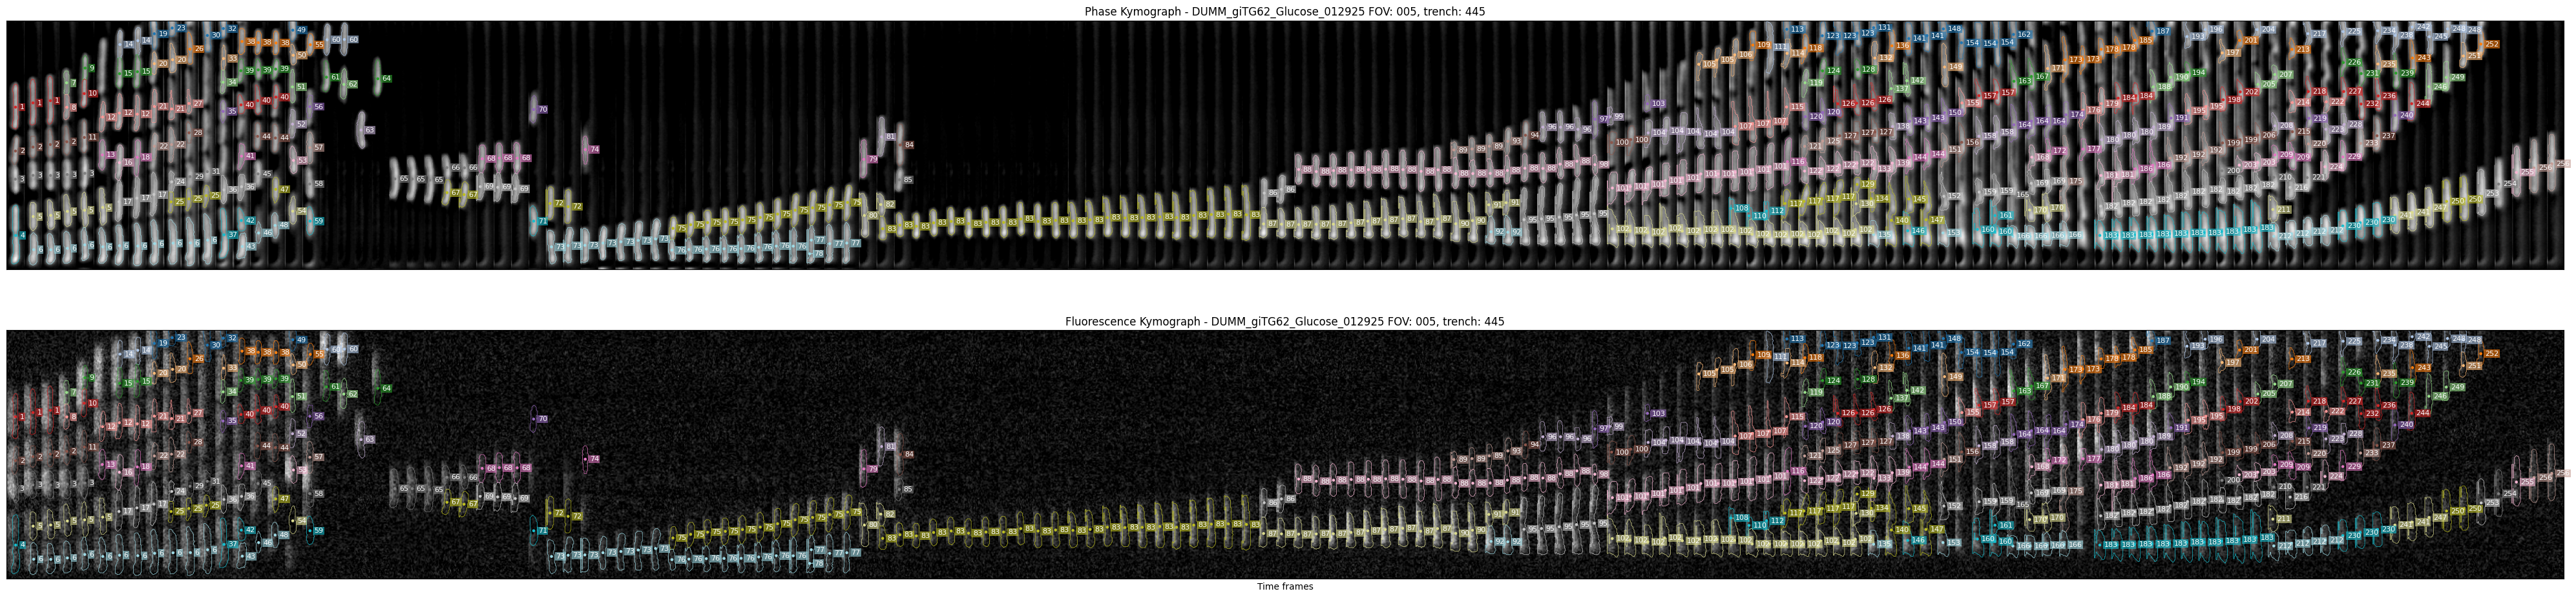

In [286]:
exp_view, fov_view, trench_view, start_t = exp_tuples[0]

df_view = all_cells_pd[(all_cells_pd['experiment_name']==exp_view) &
                       (all_cells_pd['FOV']==fov_view) &
                       (all_cells_pd['trench_id']==trench_view)].copy()


# path_to_phase_kymograph = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{exp_view}/hyperstacked/drift_corrected/drift_cor_DuMM_xy005_re_c0_2025-Jun-3-001/Fast4DReg/rotated/mm_channels/subtracted/{fov_view}_{trench_view}.tif'
# path_to_fluor_kymograph = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{exp_view}//hyperstacked/drift_corrected/drift_cor_DuMM_xy005_re_c0_2025-Jun-3-001/Fast4DReg/rotated/mm_channels/subtracted/fluor/{fov_view}_{trench_view}.tif'


# path_to_phase_kymograph = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{exp_view}/hyperstacked/drift_corrected/rotated/mm_channels/subtracted/{fov_view}_{trench_view}.tif'
# path_to_fluor_kymograph = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{exp_view}/hyperstacked/drift_corrected/rotated/mm_channels/subtracted/fluor/{fov_view}_{trench_view}.tif'

path_to_phase_kymograph = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{exp_view}/kymographs/phase/{fov_view}_{trench_view}.tif'
path_to_fluor_kymograph = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{exp_view}//kymographs/fluor/{fov_view}_{trench_view}.tif'


phase_kymograph = tifffile.imread(path_to_phase_kymograph)
fluor_kymograph = tifffile.imread(path_to_fluor_kymograph)

plot_kymograph_cells_id(phase_kymograph, fluor_kymograph, 
                                    df_view, 
                                    exp_view, fov_view, trench_view, 
                                    None, 
                                    track_id_col='track_id')

In [ ]:
ground_truth_lineage_id_dict_445 = {
    '92': 'C.2.2.2',
    '102': 'C.2.2.2', # reassing parent-daughter cell
    '117': 'C.2.2.2.1',
    '135': 'C.2.2.2.2', 

    
    '87': 'C.2.2',
    '90': 'C.2.2',
    '91': 'C.2.2.1',
    '101': 'C.2.2.1',
    '116': 'C.2.2.1',
    '122': 'C.2.2.1.2',
    '133': 'C.2.2.1.2',
    '139': 'C.2.2.1.2',
    '144': 'C.2.2.1.2',
    '151': 'C.2.2.1.2',
    '156': 'C.2.2.1.2',
    '158': 'C.2.2.1.2',
    '164': 'C.2.2.1.2',# reassing
    '174': 'C.2.2.1.2.2',
    '176': 'C.2.2.1.2.2',
    '179': 'C.2.2.1.2.2',
    '184': 'C.2.2.1.2.2',
    '188': 'C.2.2.1.2.2',
    '190': 'C.2.2.1.2.2',
    '121': 'C.2.2.1.1',
    '125': 'C.2.2.1.1',
    '127': 'C.2.2.1.1',
    '138': 'C.2.2.1.1',
    '143': 'C.2.2.1.1',
    '150': 'C.2.2.1.1',
    '155': 'C.2.2.1.1',
    '157': 'C.2.2.1.1',
    '163': 'C.2.2.1.1',
    '167': 'C.2.2.1.1',
    '171': 'C.2.2.1.1',
    '173': 'C.2.2.1.1', # reassing
    '178': 'C.2.2.1.1.2',
    '185': 'C.2.2.1.1.2',
    '187': 'C.2.2.1.1.2',
    
    '73': 'B',
    '75': 'B.1',
    '76': 'B.2',
    '80': 'C',
    '82': 'C.1',
    '83': 'C.2',
    '86': 'C.2.1',
    '88': 'C.2.1', # need to reassing half way through
    '89': 'C.2.1.1',
    '93': 'C.2.1.1',
    '94': 'C.2.1.1',
    '96': 'C.2.1.1',
    '97': 'C.2.1.1',    
    '4': 'A',
    '5': 'A.1',
    '17': 'A.1',
    '24': 'A.1.1',
    '29': 'A.1.1',
    '31': 'A.1.1',
    '41': 'A.1.1',
    '25': 'A.1.2',
    '36': 'A.1.2',
    '6': 'A.2',
    '37': 'A.2',
    '42': 'A.2.1',
    '43': 'A.2.2',
    
}

In [296]:
all_cells_pd['track_id'].unique()

array([ 19.,  23.,  30.,  32.,  49., 113., 123., 131., 141., 148., 154.,
       162., 187., 193., 196., 204., 217., 225., 234., 238., 242., 245.,
       248., 111.,  60.,  14., 185.,  38., 252., 136., 201., 109.,  26.,
        55., 118., 173., 178., 243., 213., 106., 114., 197., 132., 251.,
        20., 149.,  50.,  33., 171., 235., 105., 226., 239.,  15.,   9.,
       167.,  39., 124., 128.,  64., 163., 231.,  61., 194., 249., 142.,
       190., 246., 207.,  62.,  51., 119., 188.,  34., 137.,   7., 205.,
         1., 218., 227.,  10., 157., 202., 236., 126., 184., 244.,  40.,
       232., 198., 115., 155., 179., 222.,  21.,  27., 195., 214., 107.,
       176.,  12.,   8., 103.,  56.,  70., 240., 120., 150.,  35.,  97.,
       164., 174., 191., 143., 219.,  99., 104.,  52.,  96.,  63., 189.,
       223., 138., 208., 228., 158.,  81., 180., 237., 127.,  11.,  28.,
        94., 199., 215.,  44., 156., 206.,  84.,   2., 100., 233.,  22.,
       220.,  93., 125.,  57., 192., 151.,  89., 25

In [295]:
all_cells_pd['track_id'] = all_cells_pd['track_id'].astype(np.int64)
all_cells_pd['track_id'] = all_cells_pd['track_id'].astype(str)

IntCastingNaNError: Cannot convert non-finite values (NA or inf) to integer

In [287]:
all_cells_pd.loc[:, 'ground_truth_lineage'] = None
all_cells_pd.loc[all_cells_pd['trench_id'] ==trench_view, 'ground_truth_lineage']= all_cells_pd.loc[all_cells_pd['trench_id'] ==trench_view,'track_id'].map(ground_truth_lineage_id_dict_1061)

IntCastingNaNError: Cannot convert non-finite values (NA or inf) to integer

In [241]:
all_cells_pd.loc[all_cells_pd['trench_id'] ==trench_view]['ground_truth_lineage'].unique()

array(['A.1.1', nan, 'A.1.2', 'A.2.1.1', 'A.2.1.2', 'A.2.1', 'A.2.2.1',
       'A.2.2.2', 'B.2.1.1', 'A.1', 'B.1.1.1', 'B.1.1', 'B.2.1.2',
       'B.1.1.2', 'A.2.2', 'B.2.1', 'B.1.2.1', 'B.2.2.1.1', 'B.1.2',
       'A.2', 'B.1.2.2', 'B.2.2.1.2', 'B.2.2.1', 'B.1', 'A', 'B',
       'B.2.2.2', 'B.2.2', 'B.2.2.2.1', 'B.2', 'B.2.2.2.2'], dtype=object)

In [242]:
all_cells_pd.to_pickle(all_cells_filename)

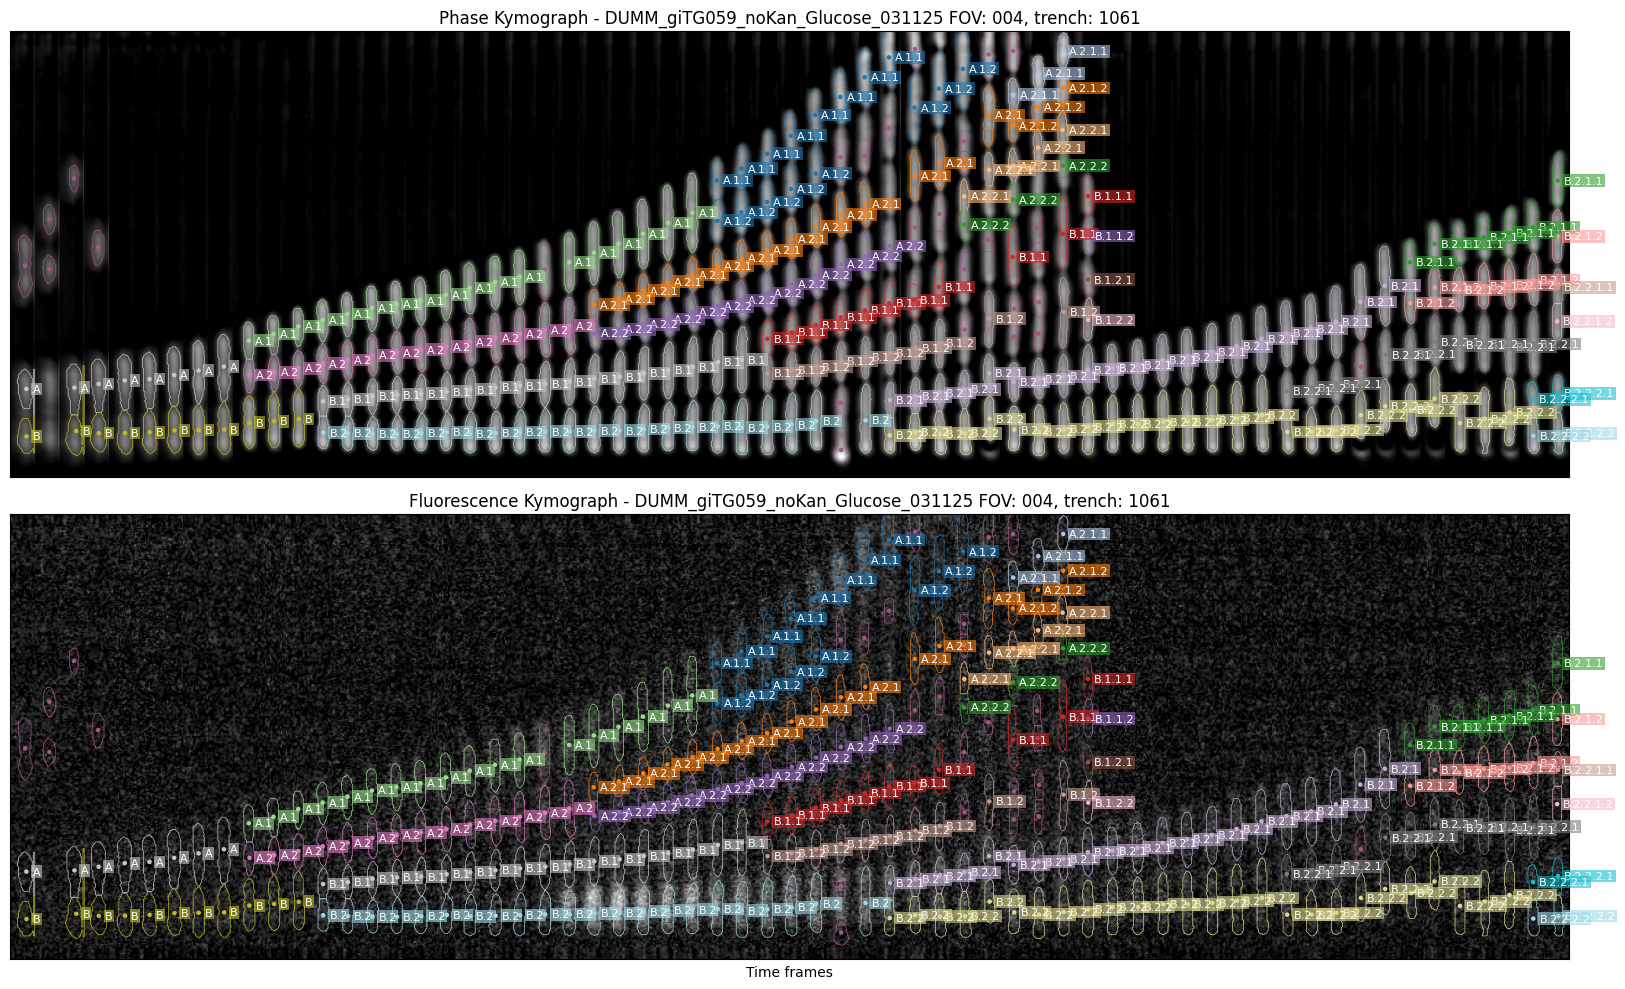

In [244]:
df_view = all_cells_pd[(all_cells_pd['experiment_name']==exp_view) &
                       (all_cells_pd['FOV']==fov_view) &
                       (all_cells_pd['trench_id']==trench_view)].copy()


# path_to_phase_kymograph = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{exp_view}/hyperstacked/drift_corrected/drift_cor_DuMM_xy005_re_c0_2025-Jun-3-001/Fast4DReg/rotated/mm_channels/subtracted/{fov_view}_{trench_view}.tif'
# path_to_fluor_kymograph = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{exp_view}//hyperstacked/drift_corrected/drift_cor_DuMM_xy005_re_c0_2025-Jun-3-001/Fast4DReg/rotated/mm_channels/subtracted/fluor/{fov_view}_{trench_view}.tif'


path_to_phase_kymograph = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{exp_view}/hyperstacked/drift_corrected/rotated/mm_channels/subtracted/{fov_view}_{trench_view}.tif'
path_to_fluor_kymograph = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{exp_view}/hyperstacked/drift_corrected/rotated/mm_channels/subtracted/fluor/{fov_view}_{trench_view}.tif'
phase_kymograph = tifffile.imread(path_to_phase_kymograph)
fluor_kymograph = tifffile.imread(path_to_fluor_kymograph)

plot_kymograph_cells_id(phase_kymograph, fluor_kymograph, 
                                    df_view, 
                                    exp_view, fov_view, trench_view, 
                                    None, 
                                    track_id_col='ground_truth_lineage')

In [ ]:
strain_exp_dict = {# need araB gitg61/CL08 lineage tracing CL008_giTG068_072925 pos 0-10 is CL08
                  # need alkA gitg63 lineage tracing potentially DUMM_giTG63_giTG67_Glucose_121724_1 pos 5, 'DUMM_giTG068_063_061725' look at pos 1-8, had pos 0 but bad for lineage
                  # need murQ gitg67 lineage tracing potenitally DUMM_giTG068_067_061825 or DUMM_giTG63_giTG67_Glucose_121724_1 pos 6-9
                  #'chpS': ['DUMM_giTG62_Glucose_012925'],  #need lineage tracing, Nora working on it
                  #'baeS':['DUMM_giTG66_Glucose_012325'],  # need lineage tracing, Adrian working on it
                  'lacZ':['DUMM_giTG059_noKan_Glucose_031125'],
                  'gfcE': ['DUMM_giTG064_Glucose_022625'],
                  'gldA': ['DUMM_giTG69_Glucose_013025'],
                  'mazF': ['DUMM_giTG059_060_061125'], # constitutive
                  'hupA':['DUMM_giTG068_052925', 'DUMM_giTG068_063_061725'] # constitutive
                  }




